# Plot surface elevations and bed topography along the centerline

In [170]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import xarray as xr
import rioxarray as rxr
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from tqdm.auto import tqdm

## Define paths in directory

In [171]:
# Path to Hubbard data for convenience
data_path = '/Users/amyjenson/Documents/GitHub/Hubbard2024/make_paper_figures/'

# Where figure will be saved
figures_out_path = data_path# os.path.join(data_path, 'make_paper_figures') 

# Bed topography
bed_fn = os.path.join(data_path, 'data', 'hubbard_bedrock_icebridge.tif')

# Centerline
cl_fn = os.path.join(data_path, 'data', 'center_50m.gpkg')

# Surface elevations
h_cl_fn = os.path.join(data_path, 'data', 'centerline_surface_elevation_timeseries_smooth.csv')

## Load data

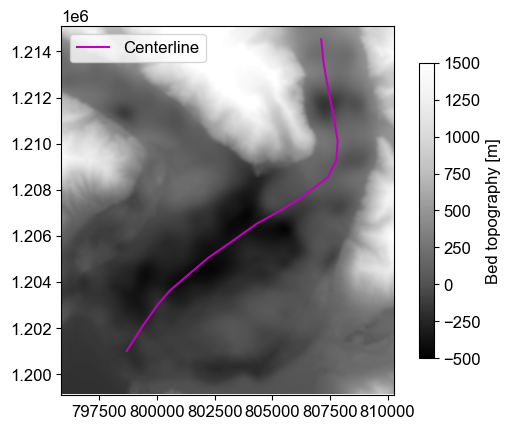

In [172]:
# Centerline
cl = gpd.read_file(cl_fn)
# calculate distance vector
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist
cl_dist = create_distance_vector(cl.geometry[0])
# Flip to start near terminus
cl_dist = np.flip(cl_dist)

# Bed
bed = xr.open_dataset(bed_fn)
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]

# Surface elevations along centerline
h_cl_df = pd.read_csv(h_cl_fn)
h_cl_df['Date'] = pd.to_datetime(h_cl_df['Date'])

# Plot bed and centerline map
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.band_data.data[0], cmap='Greys_r', clim=(-0.5e3, 1.5e3),
                   extent=(np.min(bed.x.data), np.max(bed.x.data),
                           np.min(bed.y.data), np.max(bed.y.data)))
cl.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, shrink=0.8, label='Bed topography [m]')

plt.show()

## Calculate speed peak strengths along centerline

Copied from Amy's `double_peak_strength` notebook

In [173]:
# -----Calculate summer and winter speed speaks
# Load velocity
ds_fn = os.path.join(data_path, 'data', 'Hubbard_S1.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs('EPSG:3413')
ds = ds.rio.reproject('EPSG:3338')
ds = xr.where(ds > 1e10, np.nan, ds)
ds = xr.where(ds==0, np.nan, ds)

(-0.045, -0.025)

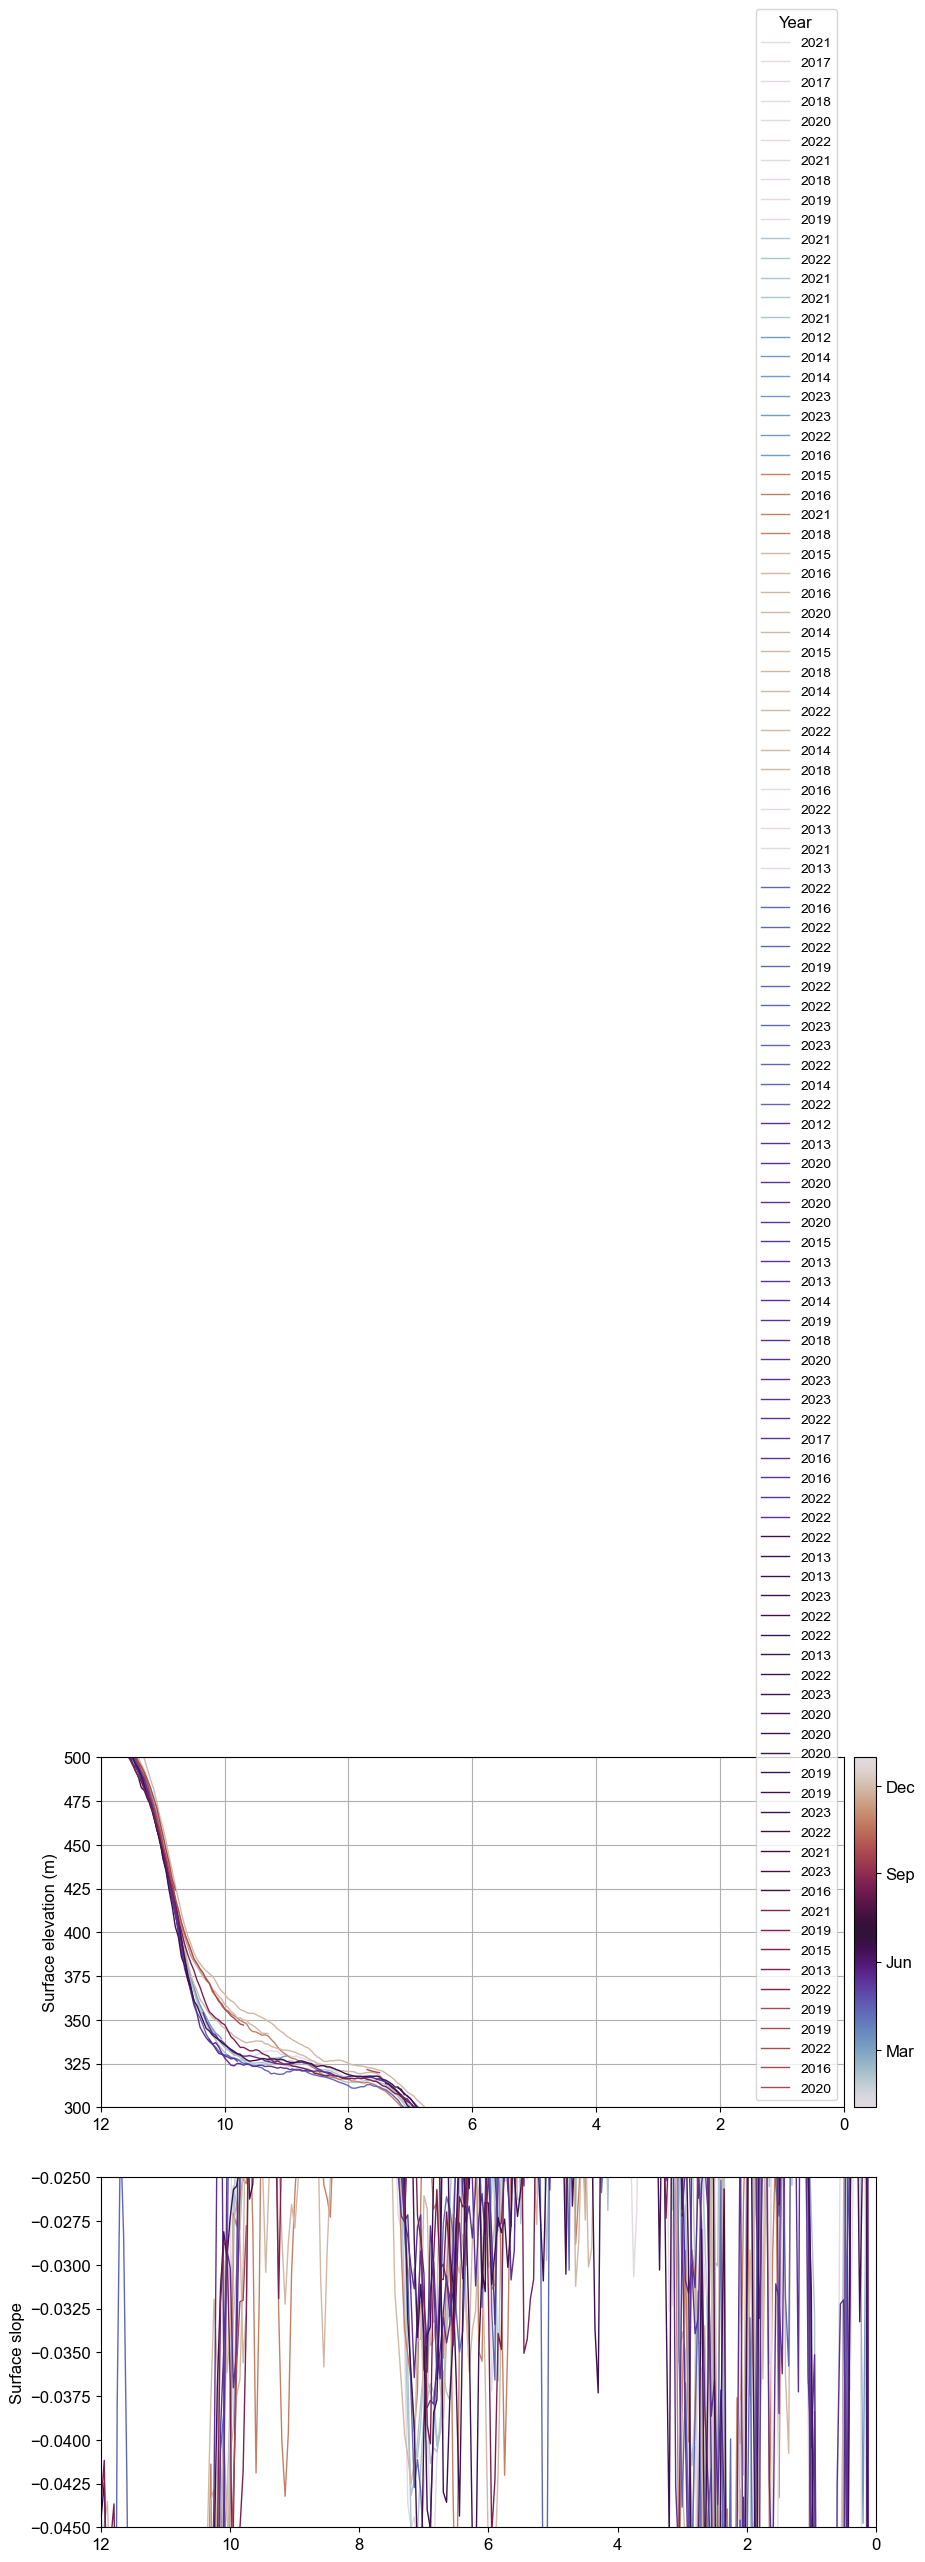

In [187]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,10))
lw=1
xlim = [12,0] # km from terminus

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

def average_slope(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')


### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])

h_cl_df['Year'] = h_cl_df['Date'].dt.year

h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
# for i in range(len(h_cl_df)):
#     month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
#     year = pd.DatetimeIndex(h_cl_df['Date']).year[i]
#     color = cmap((month-1)/11)
#     ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color, label=year)
#     #dhdx = np.gradient(h_cl_df.iloc[i][h_cols], cl_dist) 
#     # local slope (over 100 m) 
#     #ax[1].plot(np.divide(cl_dist, 1e3), -np.gradient(h_cl_df.iloc[i][h_cols], cl_dist),color=color, linewidth=lw)
#     #smoothed over 8 ice thicknesses

#     ax[1].plot(moving_average(-np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), 1),color=color, linewidth=lw)


labeled_years = set()

for i in range(len(h_cl_df)):
    month = h_cl_df['Date'].dt.month.iloc[i]
    year  = h_cl_df['Date'].dt.year.iloc[i]
    color = cmap((month - 1) / 11)

    label = str(year) #if year not in labeled_years else None
    labeled_years.add(year)

    ax[0].plot(
        np.divide(cl_dist, 1e3),
        h_cl_df.iloc[i][h_cols],
        '-',
        linewidth=lw,
        color=color,
        label=label
    )

    ax[1].plot(
        np.divide(cl_dist, 1e3),
        moving_average(-np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), 2),
        color=color,
        linewidth=lw
    )

ax[0].legend(title='Year', fontsize=10)

# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].grid()
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(300, 500)
#ax[0].set_ylim(-450, 550)

#ax[1].axhline(0, color='k', linewidth=1)
ax[1].set_ylabel('Surface slope')
ax[1].set_xlim(xlim)
#ax[1].set_ylim(-0.39, -0.32)
ax[1].set_ylim(-0.045, -0.025)

Text(0, 0.5, 'Driving stress')

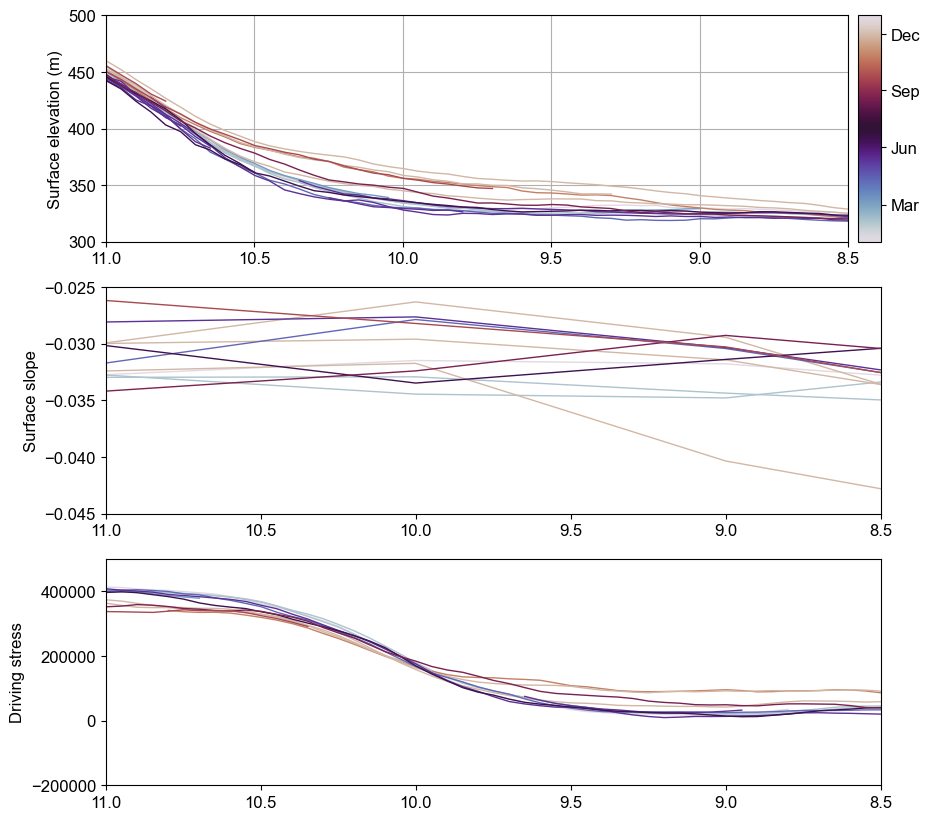

In [175]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(3, 1, figsize=(10,10))
lw=1
xlim = [11,8.5] # km from terminus
rho_i = 917
g = 9.8

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

def average_slope(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')


### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    #dhdx = np.gradient(h_cl_df.iloc[i][h_cols], cl_dist) 
    # local slope (over 100 m) 
    #ax[1].plot(np.divide(cl_dist, 1e3), -np.gradient(h_cl_df.iloc[i][h_cols], cl_dist),color=color, linewidth=lw)
    #smoothed over 8 ice thicknesses
    ax[1].plot(moving_average(-np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), 1),color=color, linewidth=lw)
    #print(h_cl_df.iloc[i][h_cols].shape)
    h = h_cl_df.iloc[i][h_cols] - bed_cl_smooth
    tan_alpha = moving_average(np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), 26)
    driving_stress = rho_i * g * h * tan_alpha
    ax[2].plot(np.divide(cl_dist, 1e3), driving_stress, '-', linewidth=lw, color=color)

ax[2].set_ylim(-2e5, 0.5e6)

# Bed
ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].grid()
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
ax[0].set_ylim(300, 500)
#ax[0].set_ylim(-450, 550)

#ax[1].axhline(0, color='k', linewidth=1)
ax[1].set_ylabel('Surface slope')
ax[1].set_xlim(xlim)
ax[2].set_xlim(xlim)
#ax[1].set_ylim(-0.39, -0.32)
ax[1].set_ylim(-0.045, -0.025)
#ax[2].set_ylim(0, 1e8)

ax[2].set_ylabel('Driving stress')

ValueError: object too deep for desired array

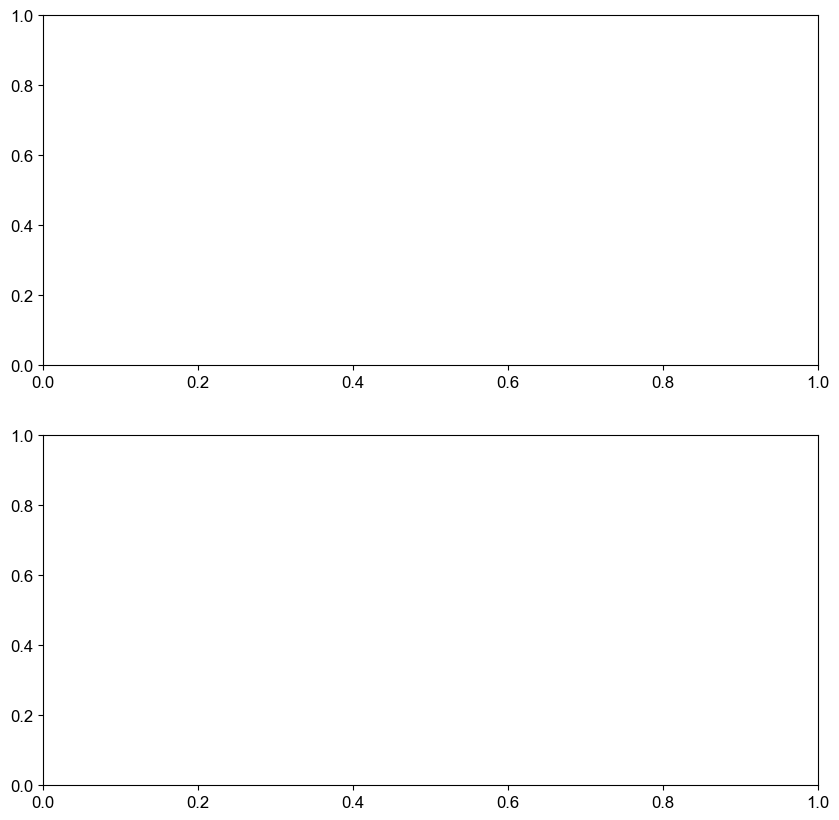

In [188]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
fig, ax = plt.subplots(2, 1, figsize=(10,10))
lw=1
xlim = [12,0] # km from terminus
rho_i = 917
g = 9.8

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

def average_slope(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df = h_cl_df.sort_values(by='Month')
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]
for i in range(len(h_cl_df)):
    month = h_cl_df.iloc[i]['Date'].month
    color = cmap((month-1)/11)
    ax[0].plot(np.divide(cl_dist, 1e3), h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
    #dhdx = np.gradient(h_cl_df.iloc[i][h_cols], cl_dist) 
    # local slope (over 100 m) 
    #ax[1].plot(np.divide(cl_dist, 1e3), -np.gradient(h_cl_df.iloc[i][h_cols], cl_dist),color=color, linewidth=lw)
    #smoothed over 8 ice thicknesses
    #ax[1].plot(moving_average(-np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), 1),color=color, linewidth=lw)
    #print(h_cl_df.iloc[i][h_cols].shape)
    h = h_cl_df.iloc[i][h_cols] - bed_cl_smooth
    sl = 32
    tan_alpha = moving_average(np.gradient(h_cl_df.iloc[i][h_cols], cl_dist), sl)
    #print(h.shape) = 359 
    #resampled_h = # h same length as 
    driving_stress = moving_average(rho_i * g * h * tan_alpha, sl) #, sl)
    ax[1].plot(np.divide(cl_dist, 1e3), driving_stress/1e3, '-', linewidth=lw, color=color)

#ax[1].set_ylim(-1e5, 0.45e6)
ax[1].set_ylim(0, 400)

# Bed
#ax[0].plot(np.divide(cl_dist, 1e3), bed_cl_smooth, '-k', linewidth=lw+1, label='Bed topography')
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
cbar = fig.colorbar(sm, cax=cax1, orientation='vertical')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
ax[0].grid()
ax[0].set_ylabel('Surface elevation (m)')
ax[0].set_xlim(xlim)
#ax[0].set_ylim(300, 500)
#ax[0].set_ylim(-450, 550)
ax[0].set_ylim(100, 550)

#ax[1].axhline(0, color='k', linewidth=1)
#ax[1].set_ylabel('Surface slope')
ax[1].set_xlim(xlim)
#ax[2].set_xlim(xlim)
#ax[1].set_ylim(-0.39, -0.32)
#ax[1].set_ylim(-0.045, -0.025)
#ax[2].set_ylim(0, 1e8)
ax[1].set_xlabel('Distance from terminus (km)')
ax[1].set_ylabel('Driving stress (kPa)')
plt.savefig('driving_stress.png')

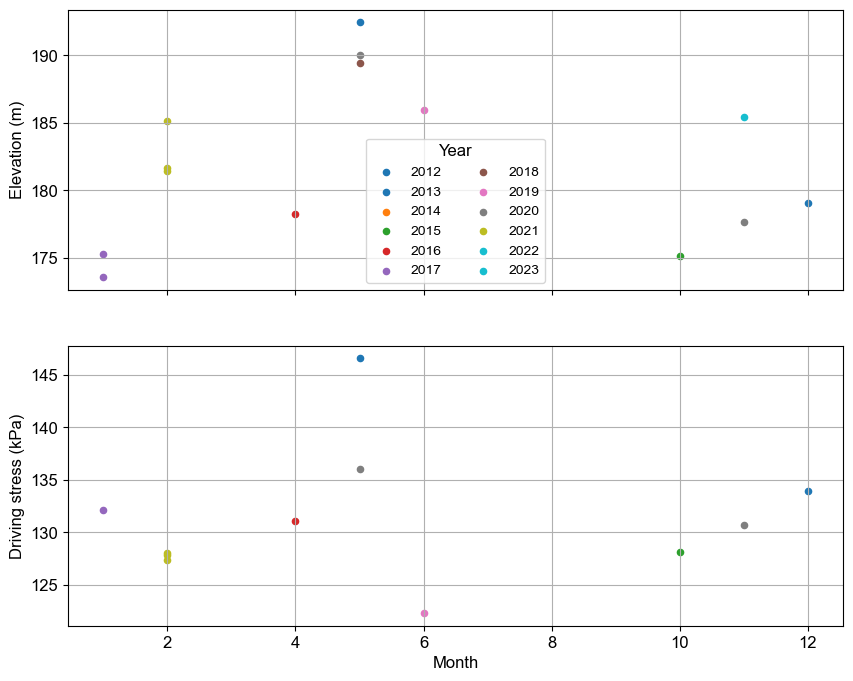

In [180]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
#fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
lw=1
xlim = [12,0] # km from terminus
rho_i = 917
g = 9.8

# Moving average for bed
def moving_average(x, w=8):
    return np.convolve(x, np.ones(w), 'same') / w
bed_cl_smooth = moving_average(bed_cl)

def average_slope(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

### a) Surface + bed elevations
# Reorder to put more drastic changes on top
h_cl_df['Month'] = pd.Categorical(h_cl_df['Date'].dt.month, [1, 2, 3, 10, 11, 12, 
                                                             4, 5, 6, 7, 8, 9])
h_cl_df['Year'] = h_cl_df['Date'].dt.year

h_cl_df = h_cl_df.sort_values(by='Month')

# Define colormap for surface profiles
cmap = plt.cm.twilight
# Surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.' in x]

x_target = 2e3  # m
idx = np.argmin(np.abs(cl_dist - x_target))

dates = h_cl_df['Month']

tau_t = np.zeros(len(h_cl_df))
h_t = np.zeros(len(h_cl_df))
slope_t = np.zeros(len(h_cl_df))

sl = 32  # 3.2 km smoothing

for i in range(len(h_cl_df)):
    h_surf = h_cl_df.iloc[i][h_cols].values
    h = h_surf - bed_cl_smooth

    tan_alpha = moving_average(np.gradient(h_surf, cl_dist), sl)
    driving_stress = moving_average(rho_i * g * h * tan_alpha, sl)

    # --- extract point ---
    tau_t[i] = driving_stress[idx] / 1e3   # kPa
    h_t[i] = h_surf[idx]
    slope_t[i] = tan_alpha[idx]
    h_cl_df['h_t'] = h_t
    h_cl_df['tau_t'] = tau_t

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

years = np.sort(h_cl_df['Year'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))

for yr, c in zip(years, colors):
    mask = h_cl_df['Year'] == yr

    ax[0].scatter(
        h_cl_df.loc[mask, 'Month'],
        h_cl_df.loc[mask, 'h_t'],
        s=20,
        color=c,
        label=str(yr)
    )

    ax[1].scatter(
        h_cl_df.loc[mask, 'Month'],
        h_cl_df.loc[mask, 'tau_t'],
        s=20,
        color=c
    )

ax[0].set_ylabel('Elevation (m)')
ax[1].set_ylabel('Driving stress (kPa)')
ax[1].set_xlabel('Month')

ax[0].legend(title='Year', ncol=2, fontsize=10)

for a in ax:
    a.grid()

# fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# ax[0].scatter(dates, h_t, s=10)
# ax[0].set_ylabel('Elevation (m)')

# # ax[1].scatter(dates, slope_t, s=20)
# # ax[1].set_ylabel(r'$\tan \alpha$')

# ax[1].scatter(dates, tau_t, s=10)
# ax[1].set_ylabel('Driving stress (kPa)')
# ax[1].set_xlabel('Month')

# for a in ax:
#     a.grid()